In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files

In [13]:
from sql_functions import get_engine 
from sql_functions import get_dataframe

In [3]:
path ='data/' 

!mkdir {path}

mkdir: data/: File exists


In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# def download_data(year, month):
#     # Get the file from the website https://transtats.bts.gov
#     zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
#     url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
#     # Download the database
#     r = requests.get(f'{url}', verify=False)
#     # Save database to local file storage
#     with open(path+zip_file, 'wb') as f:
#         f.write(r.content)
#         print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )

In [ ]:
# def extract_zip(year, month):
#     # Get the file from the website https://transtats.bts.gov
#     zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
#     with ZipFile(path+zip_file, 'r') as zip_ref:
#         zip_ref.extractall(path)
#         csv_file =  zip_ref.namelist()[0]
#         print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

In [ ]:
# years_list = [2005] # list of years you want to look at (can of course also be a single year)
# months_list = [1, 2] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
# for year in years_list:
#     for month in months_list:
# download_data(2005, 8)
# extract_zip(2005, 8)

In [ ]:
# define the name of the csv file you want to read in
# csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2005_8.csv'

# # Read in your data
# df = pd.read_csv(path+csv_file, low_memory = False)
# display(df.shape)
# display(df.head())

In [ ]:
# df.columns

In [ ]:
# columns_to_keep = [
#                 'FlightDate',
#                 'DepTime',
#                 'CRSDepTime',
#                 'DepDelay',
#                 'ArrTime',
#                 'CRSArrTime',
#                 'ArrDelay',
#                 'Reporting_Airline',
#                 'Tail_Number',
#                 'Flight_Number_Reporting_Airline',
#                 'Origin',
#                 'Dest',
#                 'AirTime',
#                 'ActualElapsedTime',
#                 'Distance',
#                 'Cancelled',
#                 'Diverted'
# ]

In [5]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database

schema = 'cgn_analytics_22_3' # UPDATE 'TABLE_SCHEMA' based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [6]:
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names    

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [7]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [8]:
df_clean = clean_airline_df(df)
df_clean.head()

NameError: name 'df' is not defined

In [14]:
df = get_dataframe('SELECT * FROM cgn_analytics_22_3.flights_katrina')

In [17]:
df_clean = clean_airline_df(df)
df_clean.head()

NameError: name 'columns_to_keep' is not defined

In [15]:
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [16]:
airports=['BTR','MSY','GPT','MOB','PNS','VPS']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.info
df_selected_airports.head() 
df_selected_airports.count()

NameError: name 'df_clean' is not defined

In [ ]:
df_selected_airports.head()

In [ ]:
df_selected_airports['cancelled'].value_counts()

In [ ]:
df_selected_airports.columns

In [ ]:
from sql_functions import get_dataframe

d_airports = get_dataframe('SELECT * FROM cgn_analytics_22_3.airports')
d_airports.head()

In [ ]:
df_selected_airports.info

In [ ]:
Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table, flights_groupname or similar
# table_name = 'flights_katrina'
# # If the specified table doesn't exist yet, it will be created
# # With 'replace', your data will be replaced if the table already exists.
# # This may take some time ...

# # Write records stored in a dataframe to SQL database
# if engine!=None:
#     try:
#         df_selected_airports.to_sql(name=table_name, # Name of SQL table
#                         con=engine, # Engine or connection
#                         if_exists='replace', # Drop the table before inserting new values 
#                         schema=schema, # Use schmea that was defined earlier
#                         index=False, # Write DataFrame index as a column
#                         chunksize=5000, # Specify the number of rows in each batch to be written at a time
#                         method='multi') # Pass multiple values in a single INSERT clause
#         print(f"The {table_name} table was imported successfully.")
#     # Error handling
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         engine = None

In [11]:
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

NameError: name 'table_name' is not defined

In [20]:
df_selected_airports = get_dataframe('SELECT * FROM cgn_analytics_22_3.flights_katrina')
df_selected_airports.info()
df_selected_airports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16331 entries, 0 to 16330
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   flight_date          16331 non-null  datetime64[ns]
 1   dep_time             14565 non-null  float64       
 2   sched_dep_time       16331 non-null  int64         
 3   dep_delay            14565 non-null  float64       
 4   arr_time             14444 non-null  float64       
 5   sched_arr_time       16331 non-null  int64         
 6   arr_delay            14444 non-null  float64       
 7   airline              16331 non-null  object        
 8   tail_number          15286 non-null  object        
 9   flight_number        16331 non-null  int64         
 10  origin               16331 non-null  object        
 11  dest                 16331 non-null  object        
 12  air_time             14444 non-null  float64       
 13  actual_elapsed_time  14444 non-

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2005-08-20,1217.0,1125,52.0,1440.0,1349,51.0,DL,N998DL,1013,MSY,ATL,67.0,83.0,425.0,0,0
1,2005-08-20,1928.0,1930,-2.0,2147.0,2159,-12.0,DL,N922DL,1023,MSY,ATL,62.0,79.0,425.0,0,0
2,2005-08-20,723.0,725,-2.0,947.0,1006,-19.0,DL,N909DA,1024,MSY,SLC,182.0,204.0,1428.0,0,0
3,2005-08-20,1214.0,1215,-1.0,1223.0,1232,-9.0,DL,N319DL,1090,ATL,GPT,50.0,69.0,352.0,0,0
4,2005-08-20,1120.0,1116,4.0,1125.0,1123,2.0,DL,N984DL,1100,ATL,VPS,41.0,65.0,250.0,0,0


In [22]:
df_selected_airports.isna().sum().sum()

12125

In [23]:
df_selected_airports.columns

Index(['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time',
       'sched_arr_time', 'arr_delay', 'airline', 'tail_number',
       'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time',
       'distance', 'cancelled', 'diverted'],
      dtype='object')

In [24]:
df_selected_airports["air_time"].isna().sum()

1887

In [25]:
df_selected_airports["dep_delay"].isna().sum()

1766

In [26]:
(df_selected_airports["cancelled"]==1).sum()

1766

In [27]:
air_time_mean = round(df_selected_airports[(df_selected_airports['flight_date'] <= '2005-08-22')].air_time.mean(), 2)
dep_delay_mean = round(df_selected_airports[(df_selected_airports['flight_date'] <= '2005-08-22')].dep_delay.mean(), 2)
cancelled_mean = round((df_selected_airports[(df_selected_airports['flight_date'] <= '2005-08-22')].cancelled.mean())*100, 2)

print(f'mean air_time before Katrina =', air_time_mean, f'min')
print(f'mean dep_delay before Katrina =', dep_delay_mean, f'min')
print(f'mean cancelled before Katrina =', cancelled_mean, f'%')

mean air_time before Katrina = 82.39 min
mean dep_delay before Katrina = 12.32 min
mean cancelled before Katrina = 2.24 %


In [28]:
before_katrina = df_selected_airports[(df_selected_airports['flight_date'] <= '2005-08-22')]

In [29]:
(before_katrina["cancelled"]==1).sum()

260

In [30]:
air_time_katrina = round(df_selected_airports[(df_selected_airports['flight_date'] >= '2005-08-23')].air_time.mean(), 2)
dep_delay_katrina = round(df_selected_airports[(df_selected_airports['flight_date'] >= '2005-08-23')].dep_delay.mean(), 2)
cancelled_katrina = round((df_selected_airports[(df_selected_airports['flight_date'] >= '2005-08-23')].cancelled.mean())*100, 2)

print(f'mean air_time during Katrina =', air_time_katrina, f'min')
print(f'mean dep_delay during Katrina =', dep_delay_katrina, f'min')
print(f'mean cancelled during Katrina =', cancelled_katrina, f'%')

mean air_time during Katrina = 79.99 min
mean dep_delay during Katrina = 7.48 min
mean cancelled during Katrina = 32.05 %


In [31]:
during_katrina = df_selected_airports[(df_selected_airports['flight_date'] >= '2005-08-23')]

In [32]:
during_katrina["air_time"].isna().sum()

1597

In [33]:
during_katrina["dep_delay"].isna().sum()

1506

In [34]:
(during_katrina["cancelled"]==1).sum()

1506

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/1389072038.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flights_by_date = df_selected_airports.groupby('flight_date').sum()


<AxesSubplot: xlabel='flight_date'>

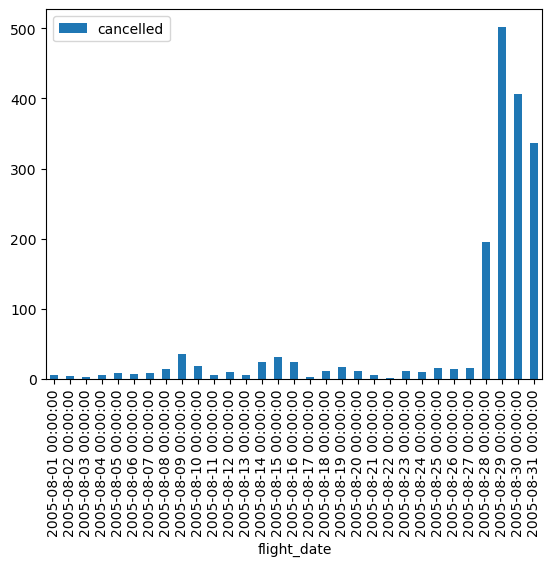

In [35]:
flights_by_date = df_selected_airports.groupby('flight_date').sum()
flights_by_date

flights_by_date.plot.bar(y="cancelled") 

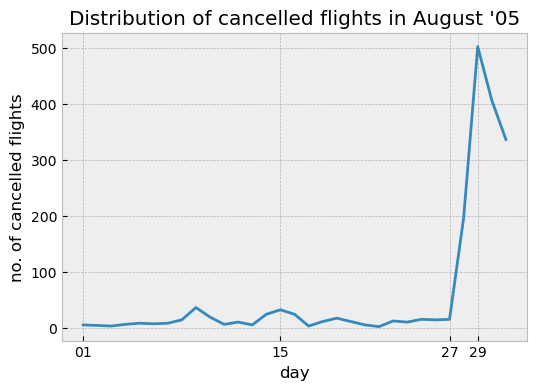

In [36]:
import matplotlib.pyplot as plt
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(flights_by_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05")

plt.show()

In [37]:
MSY_origin = df_selected_airports[(df_selected_airports['origin'] == 'MSY')]
MSY_origin_date = MSY_origin.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/1641634163.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MSY_origin_date = MSY_origin.groupby('flight_date').sum()


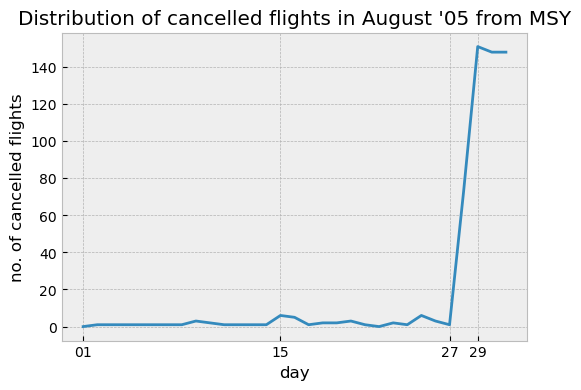

In [38]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(MSY_origin_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 from MSY")

plt.show()

In [39]:
MSY_dest = df_selected_airports[(df_selected_airports['dest'] == 'MSY')]
MSY_dest_date = MSY_dest.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/4198026105.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MSY_dest_date = MSY_dest.groupby('flight_date').sum()


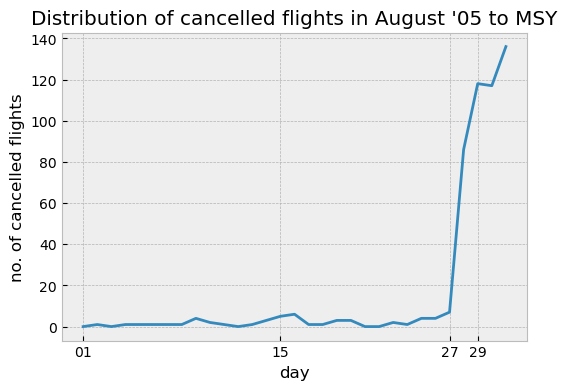

In [40]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(MSY_dest_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 to MSY")

plt.show()

In [41]:
VPS_origin = df_selected_airports[(df_selected_airports['origin'] == 'VPS')]
VPS_origin_date = VPS_origin.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/135324274.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  VPS_origin_date = VPS_origin.groupby('flight_date').sum()


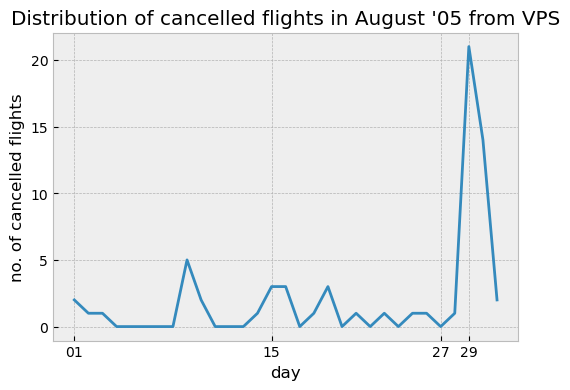

In [42]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(VPS_origin_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 from VPS")

plt.show()

In [43]:
VPS_dest = df_selected_airports[(df_selected_airports['dest'] == 'VPS')]
#VPS_dest.groupby('flight_date').sum()
VPS_dest_date = VPS_dest.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/1494808963.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  VPS_dest_date = VPS_dest.groupby('flight_date').sum()


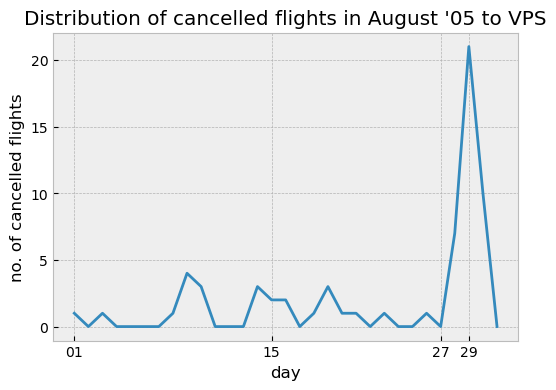

In [44]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(VPS_dest_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 to VPS")

plt.show()

In [45]:
GPT_origin = df_selected_airports[(df_selected_airports['origin'] == 'GPT')]
GPT_origin_date = GPT_origin.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/3245989323.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  GPT_origin_date = GPT_origin.groupby('flight_date').sum()


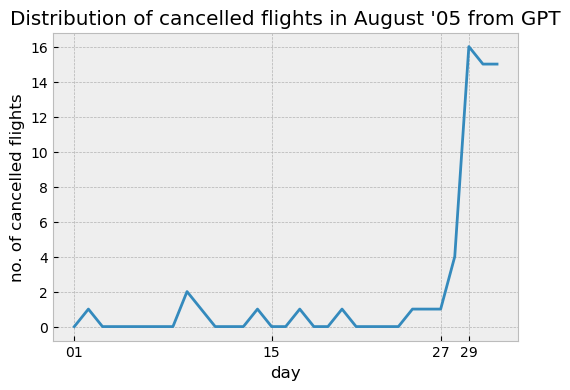

In [46]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(GPT_origin_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 from GPT")

plt.show()

In [47]:
GPT_dest = df_selected_airports[(df_selected_airports['dest'] == 'GPT')]
GPT_dest_date = GPT_dest.groupby('flight_date').sum()

/var/folders/vj/ht3c_9md4r78d2zr0h85nbhm0000gn/T/ipykernel_10673/1287347902.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  GPT_dest_date = GPT_dest.groupby('flight_date').sum()


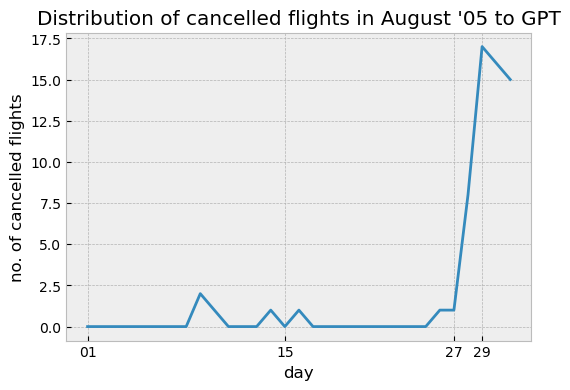

In [48]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(GPT_dest_date['cancelled']);

plt.xlabel('day')
plt.ylabel('no. of cancelled flights')

plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("Distribution of cancelled flights in August '05 to GPT")

plt.show()

In [49]:
from sql_functions import get_sql_config
get_sql_config() 

{'host': 'data-analytics-course-2.c8g8r1deus2v.eu-central-1.rds.amazonaws.com',
 'port': '5432',
 'database': 'postgres',
 'user': 'danielpaulquaintrell',
 'password': 'QWMBLovXAT9VSzlb'}

In [50]:
df_weather = get_dataframe('SELECT * FROM cgn_analytics_22_3.group_1_weather')

In [51]:
df_weather_MSY = df_weather[(df_weather['airport_code'] == 'MSY')]
df_weather_MSY

,date,avg_temp_celsius,wind_speed_kph,air_pressure_hPa,airport_code
155,2005-08-01,27.9,4.3,1016.4,MSY
156,2005-08-02,27.0,5.8,1015.9,MSY
157,2005-08-03,27.9,7.6,1015.1,MSY
158,2005-08-04,26.6,8.3,1016.7,MSY
159,2005-08-05,27.0,10.1,1017.6,MSY
160,2005-08-06,27.6,11.9,1016.3,MSY
161,2005-08-07,28.0,7.6,1015.8,MSY
162,2005-08-08,28.5,9.4,1015.4,MSY
163,2005-08-09,29.1,10.1,1015.6,MSY
164,2005-08-10,29.3,10.8,1016.1,MSY


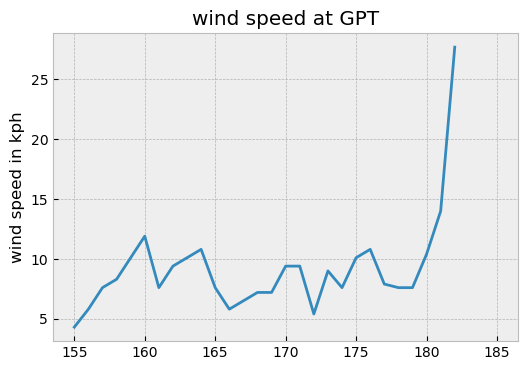

In [52]:
plt.style.use('bmh') 

plt.figure(figsize=(6, 4))

plt.plot(df_weather_MSY['wind_speed_kph']);

#plt.xlabel('day')
plt.ylabel('wind speed in kph')

#plt.xticks(['2005-08-01', '2005-08-15', '2005-08-27', '2005-08-29'], ['01', '15', '27', '29'])

plt.title("wind speed at GPT")

plt.show()

In [53]:
df_weather_VPS = df_weather[(df_weather['airport_code'] == 'VPS')]

In [54]:
df_weather_GPT = df_weather[(df_weather['airport_code'] == 'GPT')]

<AxesSubplot: xlabel='flight_date'>

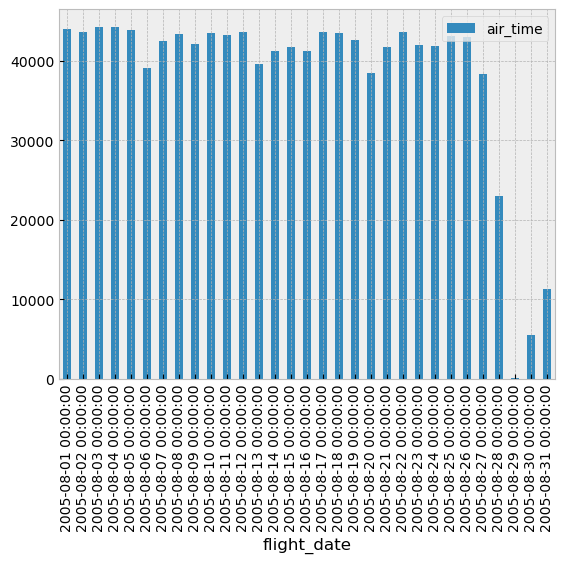

In [55]:
flights_by_date.plot.bar(y="air_time") 

In [57]:
airtime_nan_bk = before_katrina['air_time'].isna().sum()
airtime_nan_dk = during_katrina['air_time'].isna().sum()

print(f'NaN in air_time before Katrina =', airtime_nan_bk)
print(f'NaN in air_time during Katrina =', airtime_nan_dk)

NaN in air_time before Katrina = 290
NaN in air_time during Katrina = 1597


In [58]:
depdelay_nan_bk = before_katrina['dep_delay'].isna().sum()
depdelay_nan_dk = during_katrina['dep_delay'].isna().sum()

print(f'NaN in dep_delay before Katrina =', depdelay_nan_bk)
print(f'NaN in dep_delay during Katrina =', depdelay_nan_dk)

NaN in dep_delay before Katrina = 260
NaN in dep_delay during Katrina = 1506


In [60]:
cancelled_bk = (before_katrina['cancelled'] == 1).sum()
cancelled_dk = (during_katrina['cancelled'] == 1).sum()

print(f'cancelled flights before Katrina =', cancelled_bk)
print(f'cancelled flights during Katrina =', cancelled_dk)

cancelled flights before Katrina = 260
cancelled flights during Katrina = 1506


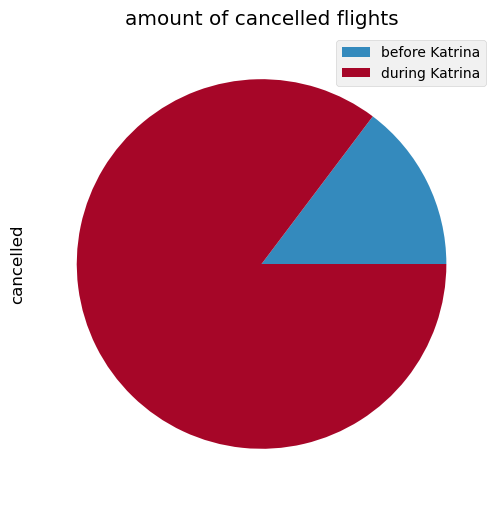

In [61]:
before_vs_during = pd.DataFrame({'cancelled': [260, 1506],
                   'mean air time': [82.39, 79.99],
                   "mean departure delay": [12.32, 7.48],
                   "diverted": [30,91]},
                  index=['before Katrina', 'during Katrina'])
plot = before_vs_during.plot.pie(figsize=(6,6),labels=None,title=("amount of cancelled flights"), y='cancelled')

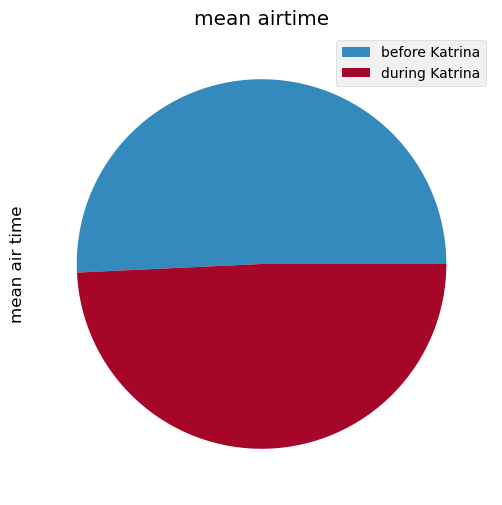

In [62]:
plot = before_vs_during.plot.pie(figsize=(6,6),title=("mean airtime"), labels=None,y='mean air time')

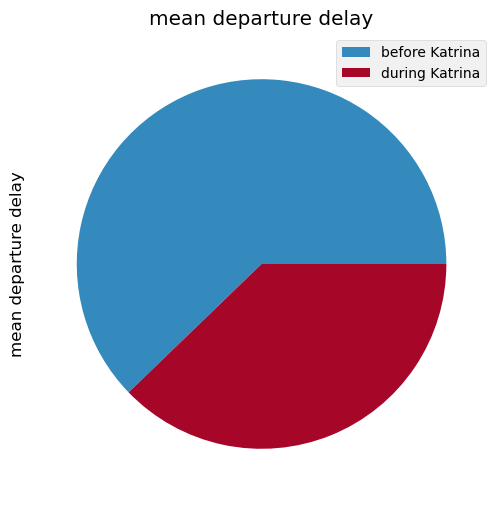

In [63]:
plot = before_vs_during.plot.pie(title=("mean departure delay"),labels=None,y='mean departure delay', figsize=(6, 6))

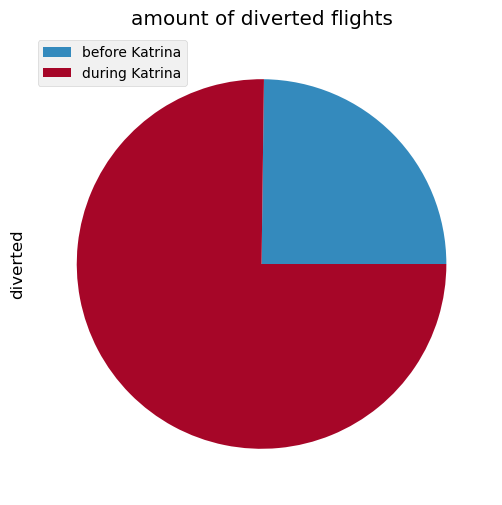

In [64]:
plot = before_vs_during.plot.pie(title= ("amount of diverted flights"),labels=None,y='diverted', figsize=(6, 6))

In [65]:
amount_null = pd.DataFrame({'airtime': [290, 1597],
                   "departure delay": [260, 1506],
                   },
                  index=['before Katrina', 'during Katrina'])

<AxesSubplot: title={'center': 'None values airtime'}, ylabel='airtime'>

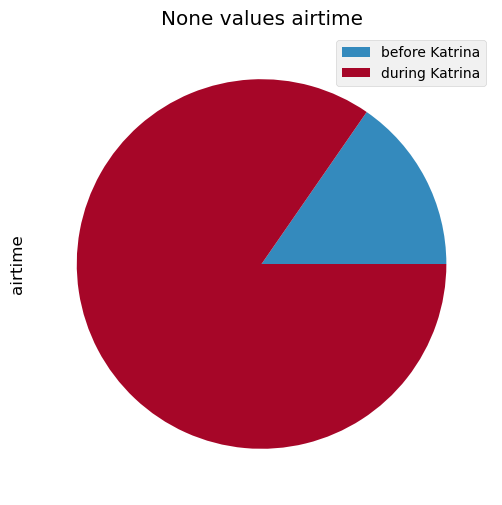

In [66]:
amount_null.plot.pie(figsize=(6,6),title=("None values airtime"),labels=None, y="airtime")

<AxesSubplot: title={'center': 'None values departure delay'}, ylabel='departure delay'>

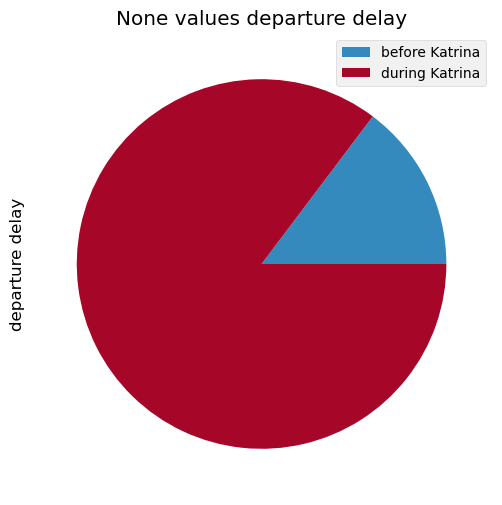

In [67]:
amount_null.plot.pie(title=("None values departure delay"),labels=None,y="departure delay",figsize=(6,6) )